# UNET Fetal A.P Diameter of Pons

## Import

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Data Generator

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        img_path = os.path.join(self.path, id_name)
        all_imgs = os.listdir(img_path)
        
        mask = np.zeros((self.image_size, self.image_size, 1))

        for name in all_imgs:
            ## Reading Image
            if "img.jpg" in name:
                _img_path = os.path.join(img_path, name)
                image = cv2.imread(_img_path, 1) # cv2.IMREAD_GRAYSCALE
                image = cv2.resize(image, (self.image_size, self.image_size))
                # image = np.expand_dims(image, axis=-1)
            ## Reading Masks
            # if ("mask1.png" in name) or ("mask2.png" in name):
            # if ("mask1.png" in name):
            if ("mask2.png" in name):
                _mask_path = os.path.join(img_path, name)
                _mask_image = cv2.imread(_mask_path, -1)
                _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
                _mask_image = np.expand_dims(_mask_image, axis=-1)
                mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [3]:
image_size = 256
train_path = "/mnt/Storage/Xuchu_Liu/Workspace/DataSet/FetalData/landmark dataset/A.P Diameter of Pons/"
epochs = 10
batch_size = 4

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 8

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 1)


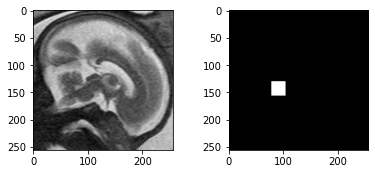

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [6]:
print("r: ", r, " id:", train_ids[r])

r:  3  id: 000007_Normal000007_d_ud


## Convolution Block

In [7]:
def conv_block(input, num_filters):
    x = keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    return x

## Encoder Block

In [8]:
# down_block(x, filters, kernel_size=(3, 3), \
#            padding="same", strides=1):
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = keras.layers.MaxPool2D((2, 2))(x)
    return x, p

## Decoder Block

In [9]:
# up_block(x, skip, filters, kernel_size=(3, 3), \
#              padding="same", strides=1):
def decoder_block(input, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

## UNET Architecture

In [10]:
def build_unet(input_shape):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = keras.models.Model(inputs, outputs, name="U-Net")
    return model

## RUN the UNET

In [11]:
if __name__ == "__main__":
    input_shape = (image_size, image_size, 3)
    model = build_unet(input_shape)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training the model

In [12]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 2 steps
Epoch 1/10
16/16 [==============================] - 7s 428ms/step - loss: 0.3092 - acc: 0.9361 - val_loss: 1587.7575 - val_acc: 0.5291
Epoch 2/10
16/16 [==============================] - 2s 126ms/step - loss: 0.1225 - acc: 0.9864 - val_loss: 284.7825 - val_acc: 0.0411
Epoch 3/10
16/16 [==============================] - 2s 126ms/step - loss: 0.0950 - acc: 0.9864 - val_loss: 101.7764 - val_acc: 0.1252
Epoch 4/10
16/16 [==============================] - 2s 125ms/step - loss: 0.0845 - acc: 0.9864 - val_loss: 42.2898 - val_acc: 0.0881
Epoch 5/10
16/16 [==============================] - 2s 123ms/step - loss: 0.0772 - acc: 0.9864 - val_loss: 0.2015 - val_acc: 0.9858
Epoch 6/10
16/16 [==============================] - 2s 123ms/step - loss: 0.0718 - acc: 0.9864 - val_loss: 0.1621 - val_acc: 0.9858
Epoch 7/10
16/16 [==============================] - 2s 126ms/step - loss: 0.0599 - acc: 0.9867 - val_loss: 5.

## Testing the model

In [13]:
## Save the Weights
model.save_weights("UNetF.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

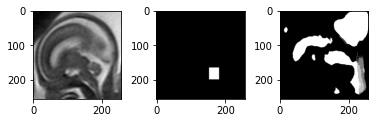

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[0])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")


In [15]:
print(" id:", valid_ids[0])

 id: 000001_Normal000001_d


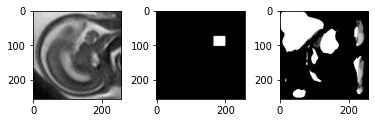

In [16]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[1])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")


In [17]:
print(" id:", valid_ids[1])

 id: 000001_Normal000001_d_90
